# Selection of the initial sample from Gaia DR3 QSO table

In [1]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
from astroquery.gaia import Gaia

Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Wednesday 4th from 11h to 12h


Selection criteria:

- Source has G band photometry publicly available and more than 20 observations. Note: Sources in the spurious table are guarateed to have a light curve.
- Source exists in the Gaia Celestial Reference Plane (CRF3)
- Source has redshift below 0.1
- Source was either classified as AGN or unclassified
- Source is not strongly contaminated by scan-angle dependent signal

In [2]:
query = """
SELECT qso.source_id, qso.redshift_qsoc, qso.vari_best_class_name, qso.vari_best_class_score, source.phot_g_mean_mag, source.bp_rp, source.ra, source.dec, spurious.spearman_corr_ipd_g_fov, spurious.num_obs_g_fov
FROM gaiadr3.qso_candidates AS qso
JOIN gaiadr3.vari_spurious_signals AS spurious USING (source_id)
JOIN gaiadr3.gaia_source AS source USING (source_id )
WHERE qso.gaia_crf_source='t'
AND spurious.num_obs_g_fov >= 20
AND qso.redshift_qsoc>0.1 
AND (spurious.spearman_corr_ipd_g_fov<0.8 OR spurious.scan_angle_model_ampl_sig_g_fov<6)
AND (qso.vari_best_class_name = 'AGN' OR qso.vari_best_class_name is NULL)
"""
job = Gaia.launch_job_async(query)
r = job.get_results()
df_selection = pl.DataFrame(r.to_pandas()).rename({'source_id': 'sourceid'}).sort('sourceid')
len(df_selection)

INFO: Query finished. [astroquery.utils.tap.core]


770110

In [3]:
df_selection.write_parquet('../data/qso_initial_selection.parquet')

## Properties of the selection

statistic,redshift_qsoc
str,f64
"""count""",770110.0
"""null_count""",0.0
"""mean""",1.675977
"""std""",1.155661
"""min""",0.1
"""25%""",0.794897
"""50%""",1.464808
"""75%""",2.286864
"""max""",6.129426


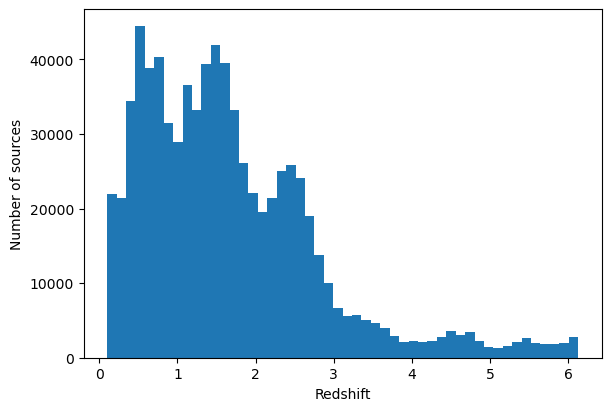

In [4]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.hist(df_selection.select('redshift_qsoc'), bins=50);
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of sources')

df_selection.select('redshift_qsoc').describe()

statistic,bp_rp
str,f64
"""count""",770095.0
"""null_count""",15.0
"""mean""",0.660931
"""std""",0.213708
"""min""",-0.595846
"""25%""",0.516443
"""50%""",0.631823
"""75%""",0.773451
"""max""",1.974451


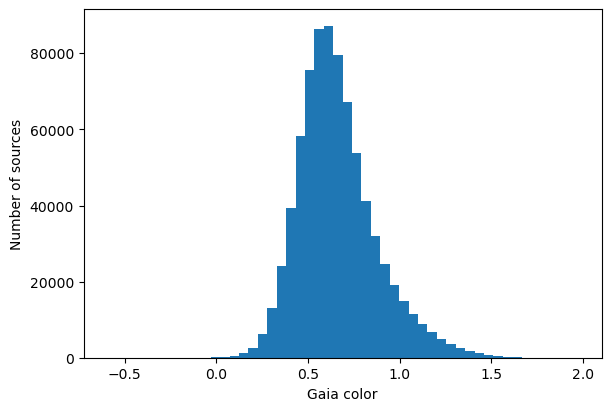

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.hist(df_selection.select('bp_rp'), bins=50);
ax.set_xlabel('Gaia color')
ax.set_ylabel('Number of sources')

df_selection.select('bp_rp').describe()

statistic,phot_g_mean_mag
str,f64
"""count""",770110.0
"""null_count""",0.0
"""mean""",19.670567
"""std""",0.745825
"""min""",13.88239
"""25%""",19.260441
"""50%""",19.825251
"""75%""",20.229177
"""max""",21.041142


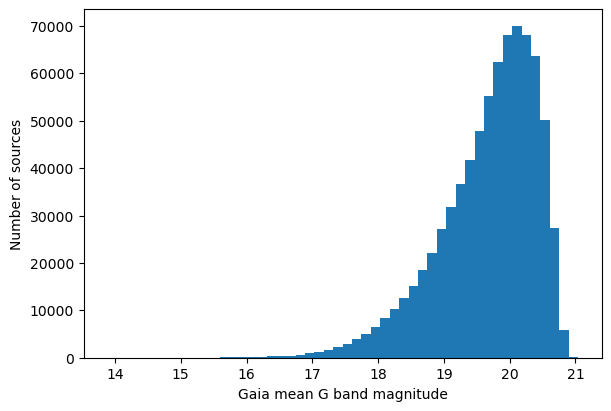

In [6]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.hist(df_selection.select('phot_g_mean_mag'), bins=50);
ax.set_xlabel('Gaia mean G band magnitude')
ax.set_ylabel('Number of sources')

df_selection.select('phot_g_mean_mag').describe()

statistic,num_obs_g_fov
str,f64
"""count""",770110.0
"""null_count""",0.0
"""mean""",41.516756
"""std""",16.050565
"""min""",20.0
"""25%""",29.0
"""50%""",39.0
"""75%""",50.0
"""max""",244.0


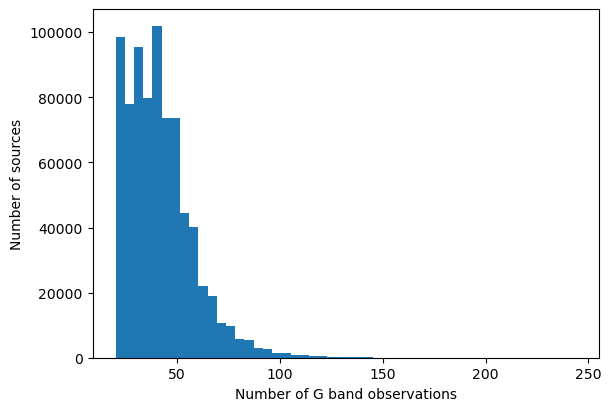

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.hist(df_selection.select('num_obs_g_fov'), bins=50);
ax.set_xlabel('Number of G band observations')
ax.set_ylabel('Number of sources')

df_selection.select('num_obs_g_fov').describe()

In [8]:
df_selection.group_by('vari_best_class_name').len()

vari_best_class_name,len
str,u32
"""AGN""",768910
"""""",1200
